# Target

- Smarthone virtual keyboard
- continuous finger motion to enter a word

# Related work

- Deep Visual-Semantic Alignments for Generating Image Descriptions; Andrej Karpathy, Li Fei-Fei
- Show, attend and tell: Neural image caption generation with visual attention; K. Xu, J. Ba, R. Kiros, K. Cho, A. Courville, R. Salakhutdinov, R.S. Zemel, Y. Bengio
- The Machine Intelligence Behind Gboard; Google Research blog

# Approach

- Deep learning tecniques for error-tolerant input
- the task is similar to image captioning hence similar architecture can be used


## Gestures generator

- it is possible to make generator of user's gestures for the samples of text from the internet and than use its outut to train a model of any complexity

### GAN as gestures generator

- gestures collection application would help to get the real user gestures dataset
- generator net produces a curve for the input word
- discriminator net gets word and corresponding curve as an input and should distinguish real user input curves from curves produced by the generator net

## Character-level RNN (LSTM) for phrase prediction

- predicts phrase character by character
- takes previous words to account
- can be trained on any text data e. g. web dumps
- can predict quotes, commas, semicolons, dots etc.
- see also [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

## Neural network architecture

- input: full gesture points sequience, repeated N times
  - code of the underlaying letter can be added as an additional coordinate for each point of sequence
- output: letters, one letter per one repeat

## Gestures CNN layers

- gesture points are time-ordered, hence it is reasonable to consider input for CNN layer as ordered array of 2D points
  - first filter gets points 1-10, second filter gets points 2-11 etc.
  - 3D points could be used if underlaying letter code is added to gesture points

## Attention

- attention layers can be used to select the right part of the curve for current letter
- see also [Attention Mechanism](https://blog.heuritech.com/2016/01/20/attention-mechanism/)


In [14]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageDraw

In [8]:
def keyboardIOS7():
    button_sz = (50, 75)

    buttons = []

    nex_pos_dist = 64

    for i in range(7, nex_pos_dist*10, nex_pos_dist):
        buttons.append((i, 25))

    for i in range(38, nex_pos_dist*9, nex_pos_dist):
        buttons.append((i, 133))

    for i in range(103, nex_pos_dist*8, nex_pos_dist):
        buttons.append((i, 240))

    letters = 'qwertyuiopasdfghjklzxcvbnm'
    return dict(zip(letters, zip(buttons, [button_sz for i in range(len(letters))])))

In [9]:
keyboard_img = 'ios-7-1-keyboard.jpg'

In [10]:
kbrd = keyboardIOS7()

In [6]:
def draw_keyboard(kbrd, img_path):
    im = Image.open(img_path)

    draw = ImageDraw.Draw(im)

    for pos, sz in kbrd.values():
        bl = (pos[0], pos[1] + sz[1])
        br = (pos[0] + sz[0], pos[1] + sz[1])
        ur = (pos[0] + sz[0], pos[1])
        draw.line([pos, ur, br, bl, pos], (220, 100, 0), width=3)
        
    return im

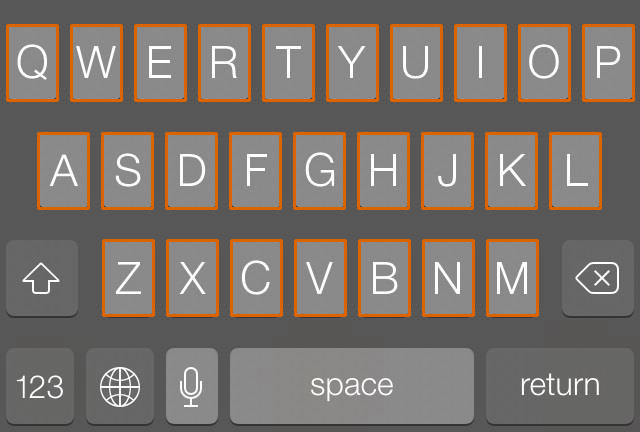

In [21]:
draw_keyboard(kbrd, keyboard_img)

In [7]:
def draw_word_line(word_line, img_path):
    im = Image.open(img_path)

    draw = ImageDraw.Draw(im)

    draw.line(word_line, (220, 100, 0), width=3)
        
    return im

In [8]:
def word_to_line(kbrd, word, randomness=0, details=10., max_points=1000):
    word = re.sub("[^a-zA-Z]", '', word).lower()
    
    fixed_word = []
    prev = ''
    for l in word:
        if l != prev:
            prev = l
            fixed_word.append(l)

    line = []
    rnd = zip(np.random.randn(len(fixed_word)), np.random.randn(len(fixed_word)))
    for letter, shift in zip(fixed_word, rnd):
        pos, sz = kbrd[letter]
        center = (pos[0] + sz[0]/2. + shift[0]*randomness, pos[1] + sz[0]/2. + shift[1]*randomness)
        line.append(center)
    
    line_full = []
    for beg, end in zip(line[:-1], line[1:]):
        line_full.extend(arc(beg, end, details))
    
    if max_points < len(line_full):
        line_full = [line_full[i] for i in sorted(random.sample(range(len(line_full)), max_points))]
        
    return line_full

In [9]:
def arc(beg, end, details=100.):
    xb, yb = beg
    xe, ye = end
    dx = xe - xb
    dy = ye - yb
    dist = (dx**2 + dy**2)**.5

    arc_r = dist/2. + 300.

    dist_center_x = xb + dx/2.
    dist_center_y = yb + dy/2.

    arc_x = dist_center_x - math.sqrt(arc_r**2-(dist/2.)**2)*dy/dist
    arc_y = dist_center_y + math.sqrt(arc_r**2-(dist/2.)**2)*dx/dist

    n_steps = 4+int(dist/details)

    beg_angle = math.atan2(arc_y-yb, arc_x-xb)
    end_angle = math.atan2(arc_y-ye, arc_x-xe)

    line = []
    for step in range(n_steps+1):
        dist = abs(end_angle - beg_angle)
        if dist > math.pi:
            dist = 2*math.pi-dist
        step_angle = beg_angle + dist*step/(n_steps)
        
        step_point_x = arc_x - arc_r*math.cos(step_angle)
        step_point_y = arc_y - arc_r*math.sin(step_angle)

        step_point = (step_point_x, step_point_y)
        line.append(step_point)
    return line

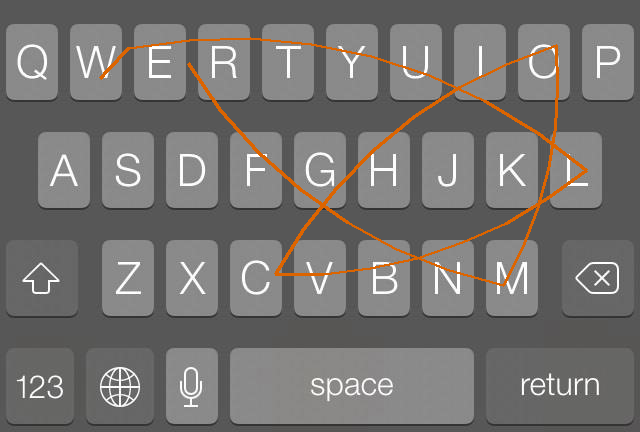

In [18]:
draw_word_line(word_to_line(kbrd, 'welcome', 20), keyboard_img)

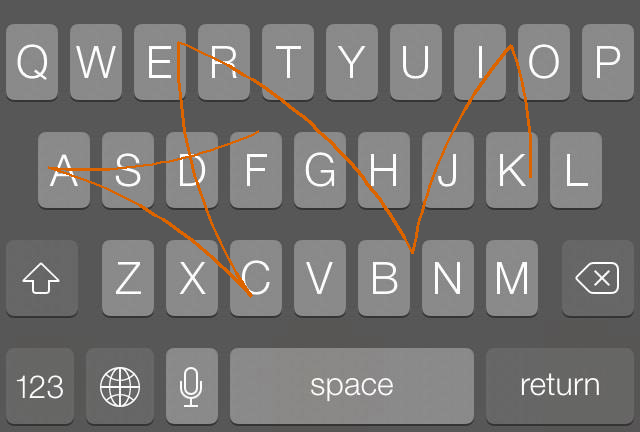

In [143]:
draw_word_line(word_to_line(kbrd, 'facebook', 20), keyboard_img)

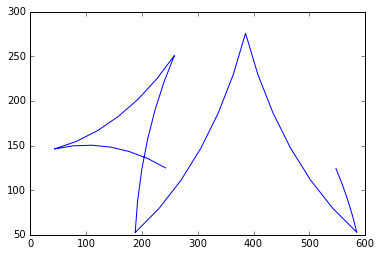

In [110]:
curve = word_to_line(kbrd, 'facebook', 20)
x, y = zip(*curve)
plt.plot(x, y)

In [287]:
def key_matrix(kbrd, img_path, char_indices):
    with Image.open(keyboard_img) as im:
        im_sz = im.size
    
    key_matrix = np.zeros(im.size, dtype=np.byte)
    key_matrix.fill(-1)
    
    for k, (pos, sz) in kbrd.items():
        key_matrix[pos[0]:pos[0]+sz[0], pos[1]:pos[1]+sz[1]] = char_indices[k]
        
    return key_matrix

In [292]:
km = key_matrix(kbrd, keyboard_img, char_indices)

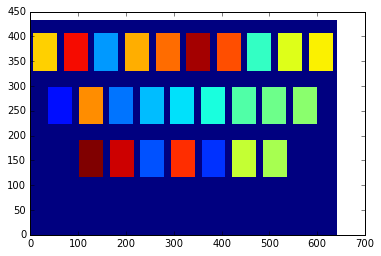

In [293]:
plt.pcolor(np.flipud(km.T))

In [17]:
with Image.open(keyboard_img) as im:
    im_size_x, im_size_y = im.size

with open('tiny-shakespeare.txt') as f:
    text = f.read().lower()
    
import re
clean_text = re.sub("[^a-zA-Z'-]", ' ', text).lower()

chars = sorted(list(set(clean_text)))
n_chars = len(chars)
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

In [322]:
def generate_input(word, n_points):
    details = 0.05*len(word)
    l = word_to_line(kbrd, word, randomness=10, details=details, max_points=n_points)
    letters = list()
    for x, y in l:
        if x <= km.shape[0] and y <= km.shape[1]:
            letters.append(km[x, y])
        else:
            letters.append(-1)
    lx, ly = zip(*l)
    return np.array(zip(lx, ly, letters), dtype=np.short)

In [323]:
def generate_dataset_words(input_text, n_points=100, max_letters=20):
    words = [
        w for w in input_text.split()
        if len(w.translate(None, "'-")) > 1
        and len(set(w)) > 1
        and len(w) <= max_letters
    ]
    
    input_len = sum([len(w) for w in words]) + len(words)

    X = np.zeros((len(words), n_points, 3), dtype=np.short)
    y = np.zeros((len(words), max_letters, n_chars), dtype=np.bool)

    shift = 0
    for word, w_pos in zip(words, range(len(words))):
        try:
            line = generate_input(word, n_points)
            X[w_pos] = line
            out = word + ' '*(max_letters-len(word))
            for char, c_pos in zip(out, range(len(out))):
                y[w_pos, c_pos, char_indices[char]] = 1
        except Exception:
            print word
            raise
        
    return X, y

In [15]:
n_points = 100
max_letters = 20

In [324]:
%%time
X, y = generate_dataset_words(clean_text, n_points=n_points, max_letters=max_letters)

/Users/dmitri/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


CPU times: user 40min 36s, sys: 1min 10s, total: 41min 47s
Wall time: 44min 17s


In [325]:
import h5py
import os

with h5py.File(os.path.expanduser('~/temp/keymagic-train-shakespeare.h5'), 'w') as f:
    f.create_dataset('X', data=X, compression="gzip")
    f.create_dataset('y', data=y, compression="gzip")

In [185]:
with h5py.File(os.path.expanduser('~/temp/keymagic-train-shakespeare.h5')) as f:
    X = f['X'][:]
    y = f['y'][:]

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, RepeatVector, TimeDistributed
from keras.layers import LSTM
from keras.layers import Convolution1D, MaxPooling1D
from keras.optimizers import RMSprop

model = Sequential()
model.add(Convolution1D(8, 4, input_shape=(n_points, 3)))
model.add(Activation('relu'))
model.add(Convolution1D(8, 4))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_length=5))
model.add(Convolution1D(1, 1))
model.add(Flatten())
model.add(RepeatVector(max_letters))
model.add(LSTM(64, return_sequences=True))
model.add(TimeDistributed(Dense(n_chars)))
model.add(TimeDistributed(Activation('softmax')))

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.01))

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution1d_16 (Convolution1D) (None, 97, 8)         104         convolution1d_input_6[0][0]      
____________________________________________________________________________________________________
activation_12 (Activation)       (None, 97, 8)         0           convolution1d_16[0][0]           
____________________________________________________________________________________________________
convolution1d_17 (Convolution1D) (None, 94, 8)         264         activation_12[0][0]              
____________________________________________________________________________________________________
activation_13 (Activation)       (None, 94, 8)         0           convolution1d_17[0][0]           
___________________________________________________________________________________________

In [327]:
model.fit(X, y, batch_size=256, nb_epoch=10)

Epoch 1/10
194146/194146 [==============================] - 133s - loss: 0.6360   
Epoch 2/10
194146/194146 [==============================] - 132s - loss: 0.4796   
Epoch 3/10
194146/194146 [==============================] - 128s - loss: 0.4482   
Epoch 4/10
194146/194146 [==============================] - 145s - loss: 0.4326   
Epoch 5/10
194146/194146 [==============================] - 141s - loss: 0.4254   
Epoch 6/10
194146/194146 [==============================] - 151s - loss: 0.4173   
Epoch 7/10
194146/194146 [==============================] - 150s - loss: 0.4107   
Epoch 8/10
194146/194146 [==============================] - 153s - loss: 0.6307   
Epoch 9/10
194146/194146 [==============================] - 164s - loss: 0.5571   
Epoch 10/10
194146/194146 [==============================] - 136s - loss: 0.4074   


In [337]:
l = generate_input('man', n_points)
p = model.predict(np.array([l]))
''.join([indices_char[ix] for ix in np.argmax(p[0], axis=1)]).strip()

/Users/dmitri/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


'man'

In [361]:
l = generate_input('say', n_points)
p = model.predict(np.array([l]))
''.join([indices_char[ix] for ix in np.argmax(p[0], axis=1)]).strip()

/Users/dmitri/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


'aay'

In [371]:
l = generate_input('citizen', n_points)
p = model.predict(np.array([l]))
''.join([indices_char[ix] for ix in np.argmax(p[0], axis=1)]).strip()

/Users/dmitri/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


'cooiiann'

In [349]:
model.save('models/keymagic-ts-10-epoch.hdf')

In [350]:
from keras.models import load_model

model = load_model('models/keymagic-ts-10-epoch.hdf')